# Deep Convolutional GAN

### Import Tensorflow & Download data

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", reshape=False, validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Build Network

#### Inputs

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

#### Generator

In [4]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

#### Discriminator

In [5]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x1
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

#### Model Loss

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

#### Optimizers

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

#### Hyper Parameters

In [9]:
real_size = (28,28,1)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

#### Define Model

In [10]:
tf.reset_default_graph()

input_real, input_z = model_inputs(real_size, z_size)

d_loss, g_loss = model_loss(input_real, input_z, real_size[2], alpha=alpha)

d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

#### view_samples

In [11]:
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    
    return fig, axes

## Training

Epoch 1/10... Discriminator Loss: 0.6497... Generator Loss: 1.0819
Epoch 1/10... Discriminator Loss: 0.4179... Generator Loss: 1.3994
Epoch 1/10... Discriminator Loss: 0.1622... Generator Loss: 2.2779
Epoch 1/10... Discriminator Loss: 0.0850... Generator Loss: 3.1742
Epoch 1/10... Discriminator Loss: 0.1350... Generator Loss: 2.9575
Epoch 1/10... Discriminator Loss: 0.0958... Generator Loss: 3.0730
Epoch 1/10... Discriminator Loss: 0.0787... Generator Loss: 3.4917
Epoch 1/10... Discriminator Loss: 0.1807... Generator Loss: 1.8786
Epoch 1/10... Discriminator Loss: 0.0584... Generator Loss: 4.1558
Epoch 1/10... Discriminator Loss: 0.0341... Generator Loss: 4.6070


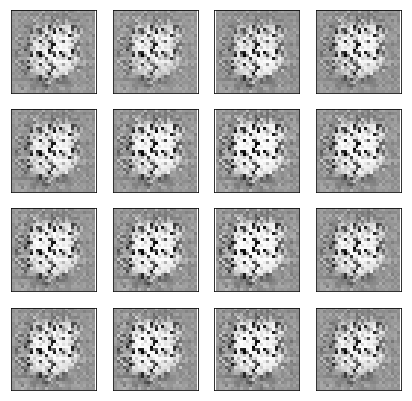

Epoch 1/10... Discriminator Loss: 0.0554... Generator Loss: 3.6015
Epoch 1/10... Discriminator Loss: 0.0535... Generator Loss: 3.7081
Epoch 1/10... Discriminator Loss: 0.3060... Generator Loss: 1.5797
Epoch 1/10... Discriminator Loss: 0.0446... Generator Loss: 3.5935
Epoch 1/10... Discriminator Loss: 0.0915... Generator Loss: 10.9678
Epoch 1/10... Discriminator Loss: 0.0500... Generator Loss: 8.7823
Epoch 1/10... Discriminator Loss: 0.1676... Generator Loss: 3.8742
Epoch 1/10... Discriminator Loss: 0.0883... Generator Loss: 4.3105
Epoch 1/10... Discriminator Loss: 0.0560... Generator Loss: 3.7275
Epoch 1/10... Discriminator Loss: 0.0878... Generator Loss: 4.3047


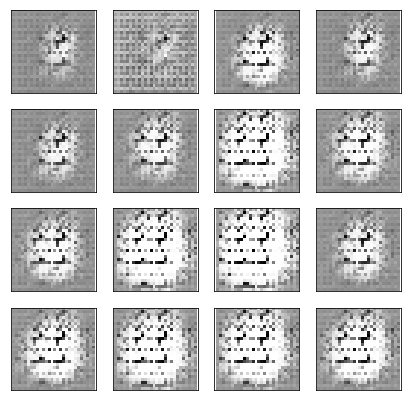

Epoch 1/10... Discriminator Loss: 0.0942... Generator Loss: 3.4572
Epoch 1/10... Discriminator Loss: 0.1210... Generator Loss: 3.0711
Epoch 1/10... Discriminator Loss: 0.0536... Generator Loss: 3.7137
Epoch 1/10... Discriminator Loss: 0.0457... Generator Loss: 3.6087
Epoch 1/10... Discriminator Loss: 0.0976... Generator Loss: 3.7403
Epoch 1/10... Discriminator Loss: 0.0834... Generator Loss: 3.8235
Epoch 1/10... Discriminator Loss: 0.0695... Generator Loss: 3.6640
Epoch 1/10... Discriminator Loss: 0.1964... Generator Loss: 1.9805
Epoch 1/10... Discriminator Loss: 0.0462... Generator Loss: 4.0222
Epoch 1/10... Discriminator Loss: 0.0495... Generator Loss: 4.2715


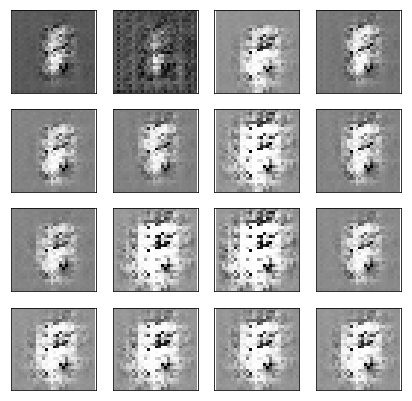

Epoch 1/10... Discriminator Loss: 0.0741... Generator Loss: 3.7060
Epoch 1/10... Discriminator Loss: 0.1673... Generator Loss: 2.4973
Epoch 1/10... Discriminator Loss: 0.0915... Generator Loss: 2.9158
Epoch 1/10... Discriminator Loss: 0.1066... Generator Loss: 3.4691
Epoch 1/10... Discriminator Loss: 0.0410... Generator Loss: 6.4220
Epoch 1/10... Discriminator Loss: 0.1007... Generator Loss: 4.4824
Epoch 1/10... Discriminator Loss: 0.0614... Generator Loss: 4.4103
Epoch 1/10... Discriminator Loss: 0.1160... Generator Loss: 4.3807
Epoch 1/10... Discriminator Loss: 0.1430... Generator Loss: 3.2197
Epoch 1/10... Discriminator Loss: 0.0728... Generator Loss: 4.2470


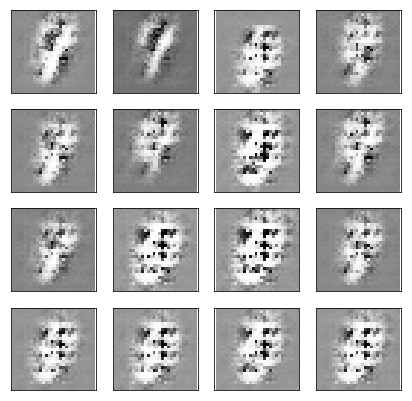

Epoch 1/10... Discriminator Loss: 0.0635... Generator Loss: 3.6619
Epoch 1/10... Discriminator Loss: 0.0760... Generator Loss: 3.7027
Epoch 1/10... Discriminator Loss: 0.1173... Generator Loss: 3.1415
Epoch 1/10... Discriminator Loss: 0.0866... Generator Loss: 3.2615
Epoch 1/10... Discriminator Loss: 0.0890... Generator Loss: 3.2936
Epoch 1/10... Discriminator Loss: 0.0569... Generator Loss: 4.9057
Epoch 2/10... Discriminator Loss: 0.0498... Generator Loss: 4.2268
Epoch 2/10... Discriminator Loss: 0.0375... Generator Loss: 5.4380
Epoch 2/10... Discriminator Loss: 0.0580... Generator Loss: 3.6263
Epoch 2/10... Discriminator Loss: 0.0294... Generator Loss: 5.7105


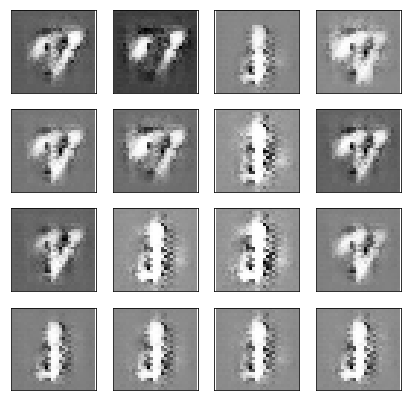

Epoch 2/10... Discriminator Loss: 0.0464... Generator Loss: 3.7572
Epoch 2/10... Discriminator Loss: 0.0559... Generator Loss: 3.5784
Epoch 2/10... Discriminator Loss: 0.0438... Generator Loss: 3.8313
Epoch 2/10... Discriminator Loss: 0.0820... Generator Loss: 3.7318
Epoch 2/10... Discriminator Loss: 0.0698... Generator Loss: 3.9337
Epoch 2/10... Discriminator Loss: 0.0504... Generator Loss: 4.6429
Epoch 2/10... Discriminator Loss: 0.0380... Generator Loss: 4.7714
Epoch 2/10... Discriminator Loss: 0.1091... Generator Loss: 7.8416
Epoch 2/10... Discriminator Loss: 0.1851... Generator Loss: 2.9476
Epoch 2/10... Discriminator Loss: 0.0918... Generator Loss: 3.8138


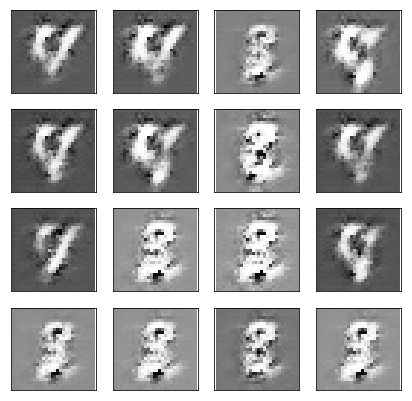

Epoch 2/10... Discriminator Loss: 0.0446... Generator Loss: 3.9890
Epoch 2/10... Discriminator Loss: 0.0748... Generator Loss: 3.1034
Epoch 2/10... Discriminator Loss: 0.0430... Generator Loss: 4.5233
Epoch 2/10... Discriminator Loss: 0.0495... Generator Loss: 4.0778
Epoch 2/10... Discriminator Loss: 0.0497... Generator Loss: 3.5731
Epoch 2/10... Discriminator Loss: 0.0362... Generator Loss: 4.4243
Epoch 2/10... Discriminator Loss: 0.0349... Generator Loss: 4.5144
Epoch 2/10... Discriminator Loss: 0.0318... Generator Loss: 4.4967
Epoch 2/10... Discriminator Loss: 0.0441... Generator Loss: 3.6738
Epoch 2/10... Discriminator Loss: 0.0431... Generator Loss: 4.1218


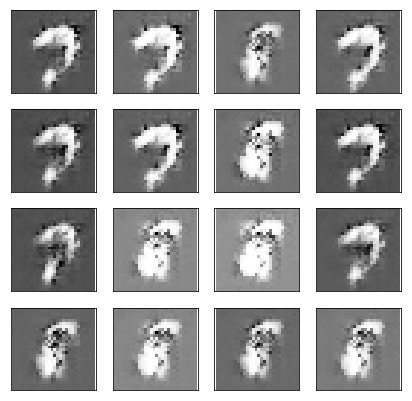

Epoch 2/10... Discriminator Loss: 0.0674... Generator Loss: 3.1973
Epoch 2/10... Discriminator Loss: 0.0354... Generator Loss: 4.5256
Epoch 2/10... Discriminator Loss: 0.0368... Generator Loss: 4.3332
Epoch 2/10... Discriminator Loss: 0.0383... Generator Loss: 3.8964
Epoch 2/10... Discriminator Loss: 0.0585... Generator Loss: 4.0860
Epoch 2/10... Discriminator Loss: 0.0307... Generator Loss: 4.2478
Epoch 2/10... Discriminator Loss: 0.0155... Generator Loss: 6.8989
Epoch 2/10... Discriminator Loss: 0.0252... Generator Loss: 5.1641
Epoch 2/10... Discriminator Loss: 0.0286... Generator Loss: 3.9231
Epoch 2/10... Discriminator Loss: 0.0233... Generator Loss: 5.2838


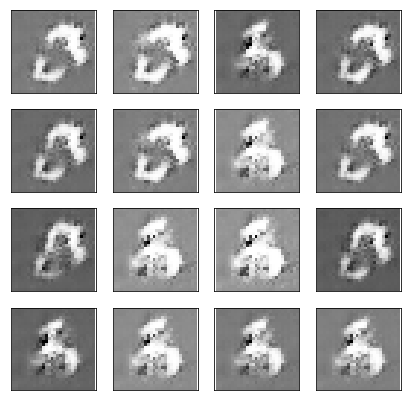

Epoch 2/10... Discriminator Loss: 0.0357... Generator Loss: 3.9337
Epoch 2/10... Discriminator Loss: 0.0147... Generator Loss: 5.1113
Epoch 2/10... Discriminator Loss: 0.0211... Generator Loss: 4.8056
Epoch 2/10... Discriminator Loss: 0.0380... Generator Loss: 4.7152
Epoch 2/10... Discriminator Loss: 0.0251... Generator Loss: 5.3746
Epoch 2/10... Discriminator Loss: 0.0330... Generator Loss: 3.9242
Epoch 2/10... Discriminator Loss: 0.0260... Generator Loss: 4.1463
Epoch 2/10... Discriminator Loss: 0.0327... Generator Loss: 4.4271
Epoch 2/10... Discriminator Loss: 0.0130... Generator Loss: 5.5209
Epoch 2/10... Discriminator Loss: 0.0346... Generator Loss: 5.5357


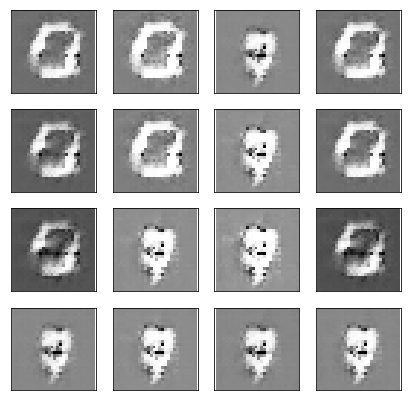

Epoch 2/10... Discriminator Loss: 0.0207... Generator Loss: 5.1653
Epoch 2/10... Discriminator Loss: 0.0325... Generator Loss: 5.6936
Epoch 2/10... Discriminator Loss: 0.0157... Generator Loss: 4.8311
Epoch 3/10... Discriminator Loss: 0.0314... Generator Loss: 3.9289
Epoch 3/10... Discriminator Loss: 0.0219... Generator Loss: 4.5581
Epoch 3/10... Discriminator Loss: 0.0491... Generator Loss: 3.7001
Epoch 3/10... Discriminator Loss: 0.0361... Generator Loss: 5.0193
Epoch 3/10... Discriminator Loss: 0.0216... Generator Loss: 4.3970
Epoch 3/10... Discriminator Loss: 0.0303... Generator Loss: 4.0531
Epoch 3/10... Discriminator Loss: 0.0232... Generator Loss: 4.4762


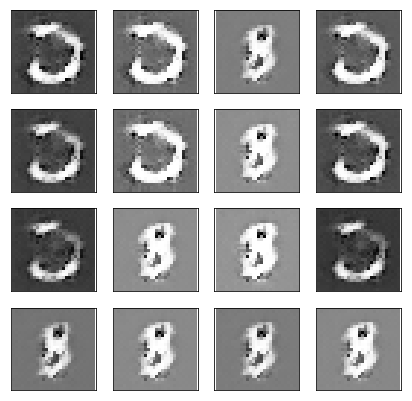

Epoch 3/10... Discriminator Loss: 0.0403... Generator Loss: 3.8362
Epoch 3/10... Discriminator Loss: 0.0253... Generator Loss: 4.9320
Epoch 3/10... Discriminator Loss: 0.0111... Generator Loss: 5.4333
Epoch 3/10... Discriminator Loss: 0.0197... Generator Loss: 4.7349
Epoch 3/10... Discriminator Loss: 0.0198... Generator Loss: 4.7132
Epoch 3/10... Discriminator Loss: 0.0210... Generator Loss: 4.5880
Epoch 3/10... Discriminator Loss: 0.0137... Generator Loss: 5.0669
Epoch 3/10... Discriminator Loss: 0.0091... Generator Loss: 5.5523
Epoch 3/10... Discriminator Loss: 0.0138... Generator Loss: 5.1966
Epoch 3/10... Discriminator Loss: 0.0107... Generator Loss: 5.1000


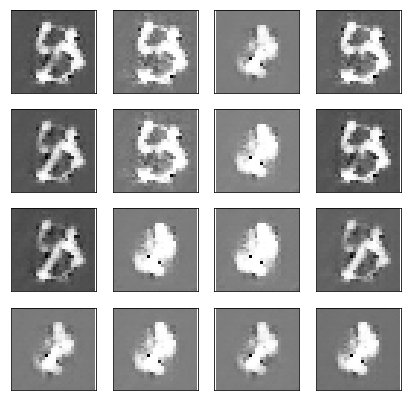

Epoch 3/10... Discriminator Loss: 0.0070... Generator Loss: 6.7223
Epoch 3/10... Discriminator Loss: 0.0147... Generator Loss: 5.3797
Epoch 3/10... Discriminator Loss: 0.0260... Generator Loss: 4.4647
Epoch 3/10... Discriminator Loss: 0.0369... Generator Loss: 3.5185
Epoch 3/10... Discriminator Loss: 0.0096... Generator Loss: 6.0598
Epoch 3/10... Discriminator Loss: 0.0410... Generator Loss: 3.7143
Epoch 3/10... Discriminator Loss: 0.0089... Generator Loss: 6.2045
Epoch 3/10... Discriminator Loss: 0.0189... Generator Loss: 6.9640
Epoch 3/10... Discriminator Loss: 0.0156... Generator Loss: 5.0090
Epoch 3/10... Discriminator Loss: 0.0119... Generator Loss: 5.4725


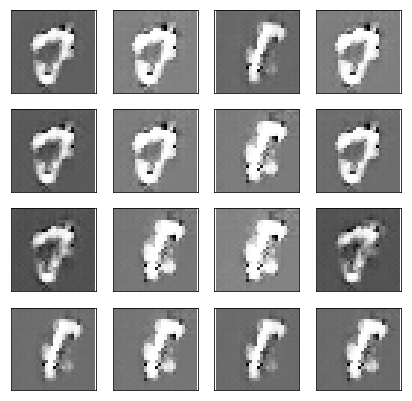

Epoch 3/10... Discriminator Loss: 0.0113... Generator Loss: 5.4303
Epoch 3/10... Discriminator Loss: 0.0076... Generator Loss: 5.8931
Epoch 3/10... Discriminator Loss: 0.0079... Generator Loss: 5.6311
Epoch 3/10... Discriminator Loss: 0.0099... Generator Loss: 5.4761
Epoch 3/10... Discriminator Loss: 0.0112... Generator Loss: 5.0043
Epoch 3/10... Discriminator Loss: 0.0148... Generator Loss: 4.7861
Epoch 3/10... Discriminator Loss: 0.0196... Generator Loss: 4.1778
Epoch 3/10... Discriminator Loss: 0.0155... Generator Loss: 4.6151
Epoch 3/10... Discriminator Loss: 0.0142... Generator Loss: 5.4887
Epoch 3/10... Discriminator Loss: 0.0114... Generator Loss: 5.4782


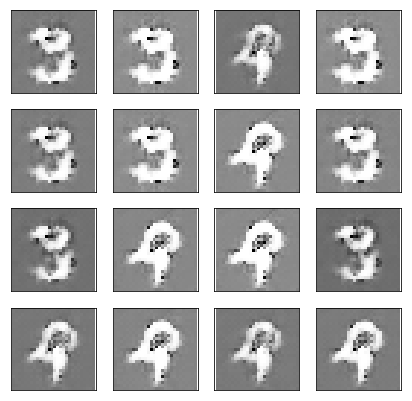

Epoch 3/10... Discriminator Loss: 0.0110... Generator Loss: 5.5326
Epoch 3/10... Discriminator Loss: 0.0128... Generator Loss: 4.9558
Epoch 3/10... Discriminator Loss: 0.0063... Generator Loss: 6.5238
Epoch 3/10... Discriminator Loss: 0.0154... Generator Loss: 4.6061
Epoch 3/10... Discriminator Loss: 0.0117... Generator Loss: 5.5926
Epoch 3/10... Discriminator Loss: 0.0038... Generator Loss: 6.6598
Epoch 3/10... Discriminator Loss: 0.0938... Generator Loss: 13.4631
Epoch 3/10... Discriminator Loss: 0.1109... Generator Loss: 14.2060
Epoch 3/10... Discriminator Loss: 0.1700... Generator Loss: 3.8804
Epoch 3/10... Discriminator Loss: 0.0701... Generator Loss: 3.5320


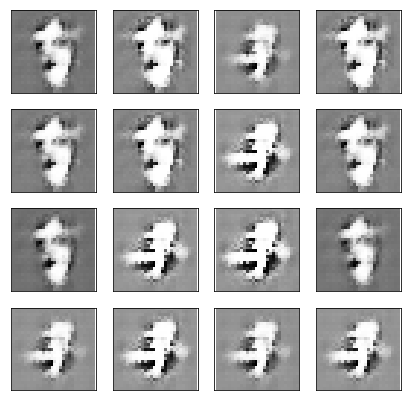

Epoch 4/10... Discriminator Loss: 0.0425... Generator Loss: 4.0077
Epoch 4/10... Discriminator Loss: 0.0227... Generator Loss: 4.3550
Epoch 4/10... Discriminator Loss: 0.0348... Generator Loss: 4.0435
Epoch 4/10... Discriminator Loss: 0.0294... Generator Loss: 4.2824
Epoch 4/10... Discriminator Loss: 0.0270... Generator Loss: 4.6286
Epoch 4/10... Discriminator Loss: 0.0269... Generator Loss: 4.7614
Epoch 4/10... Discriminator Loss: 0.0231... Generator Loss: 4.6029
Epoch 4/10... Discriminator Loss: 0.0160... Generator Loss: 4.6779
Epoch 4/10... Discriminator Loss: 0.0149... Generator Loss: 4.9640
Epoch 4/10... Discriminator Loss: 0.0293... Generator Loss: 4.2391


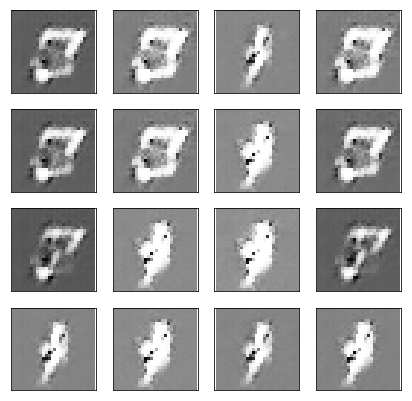

Epoch 4/10... Discriminator Loss: 0.0323... Generator Loss: 4.1323
Epoch 4/10... Discriminator Loss: 0.0092... Generator Loss: 6.0890
Epoch 4/10... Discriminator Loss: 0.0180... Generator Loss: 4.8062
Epoch 4/10... Discriminator Loss: 0.0245... Generator Loss: 4.4771
Epoch 4/10... Discriminator Loss: 0.0218... Generator Loss: 4.5988
Epoch 4/10... Discriminator Loss: 0.0170... Generator Loss: 5.3225
Epoch 4/10... Discriminator Loss: 0.0160... Generator Loss: 4.8256
Epoch 4/10... Discriminator Loss: 0.0105... Generator Loss: 5.5515
Epoch 4/10... Discriminator Loss: 0.0145... Generator Loss: 4.9893
Epoch 4/10... Discriminator Loss: 0.0136... Generator Loss: 5.2042


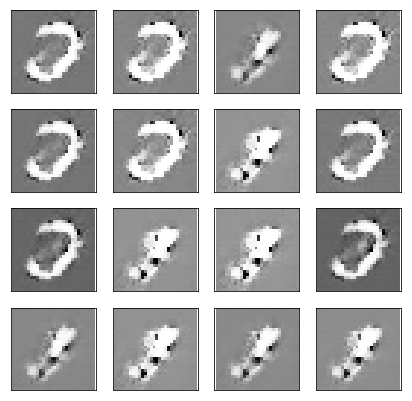

Epoch 4/10... Discriminator Loss: 0.0187... Generator Loss: 4.6938
Epoch 4/10... Discriminator Loss: 0.0178... Generator Loss: 5.1341
Epoch 4/10... Discriminator Loss: 0.0208... Generator Loss: 5.9333
Epoch 4/10... Discriminator Loss: 0.0131... Generator Loss: 5.2082
Epoch 4/10... Discriminator Loss: 0.0129... Generator Loss: 4.9652
Epoch 4/10... Discriminator Loss: 0.0082... Generator Loss: 5.7397
Epoch 4/10... Discriminator Loss: 0.0115... Generator Loss: 5.0378
Epoch 4/10... Discriminator Loss: 0.0190... Generator Loss: 5.3430
Epoch 4/10... Discriminator Loss: 0.0216... Generator Loss: 4.3651
Epoch 4/10... Discriminator Loss: 0.0192... Generator Loss: 5.7440


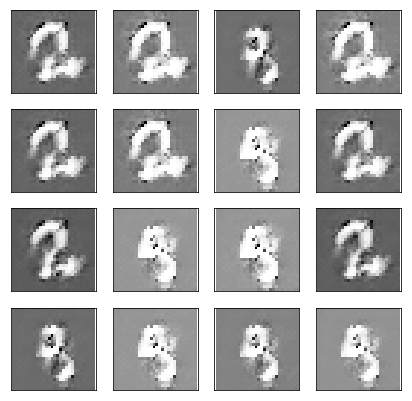

Epoch 4/10... Discriminator Loss: 0.0156... Generator Loss: 5.3336
Epoch 4/10... Discriminator Loss: 0.0164... Generator Loss: 4.7853
Epoch 4/10... Discriminator Loss: 0.0134... Generator Loss: 5.2352
Epoch 4/10... Discriminator Loss: 0.0093... Generator Loss: 5.8036
Epoch 4/10... Discriminator Loss: 0.0167... Generator Loss: 5.1510
Epoch 4/10... Discriminator Loss: 0.0131... Generator Loss: 4.9176
Epoch 4/10... Discriminator Loss: 0.0382... Generator Loss: 4.0902
Epoch 4/10... Discriminator Loss: 0.0063... Generator Loss: 5.3005
Epoch 4/10... Discriminator Loss: 0.0294... Generator Loss: 5.3760
Epoch 4/10... Discriminator Loss: 0.0495... Generator Loss: 3.7100


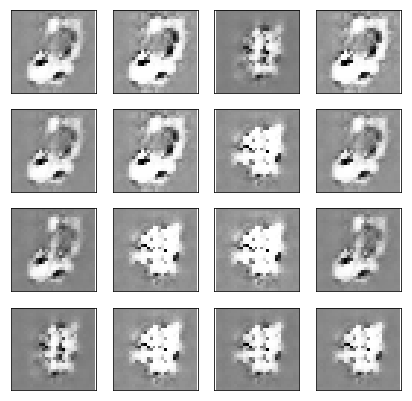

Epoch 4/10... Discriminator Loss: 0.0213... Generator Loss: 4.5998
Epoch 4/10... Discriminator Loss: 0.0158... Generator Loss: 5.0314
Epoch 4/10... Discriminator Loss: 0.0235... Generator Loss: 4.4636
Epoch 4/10... Discriminator Loss: 0.0168... Generator Loss: 4.8941
Epoch 4/10... Discriminator Loss: 0.0183... Generator Loss: 4.9999
Epoch 4/10... Discriminator Loss: 0.0246... Generator Loss: 4.4243
Epoch 4/10... Discriminator Loss: 0.0216... Generator Loss: 4.6554
Epoch 5/10... Discriminator Loss: 0.0181... Generator Loss: 4.7470
Epoch 5/10... Discriminator Loss: 0.0204... Generator Loss: 4.7917
Epoch 5/10... Discriminator Loss: 0.0190... Generator Loss: 4.8302


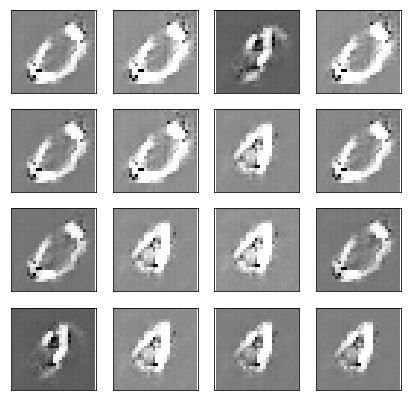

Epoch 5/10... Discriminator Loss: 0.0199... Generator Loss: 4.9501
Epoch 5/10... Discriminator Loss: 0.0114... Generator Loss: 5.1577
Epoch 5/10... Discriminator Loss: 0.0151... Generator Loss: 4.9805
Epoch 5/10... Discriminator Loss: 0.0124... Generator Loss: 4.8295
Epoch 5/10... Discriminator Loss: 0.0220... Generator Loss: 4.3768
Epoch 5/10... Discriminator Loss: 0.0178... Generator Loss: 4.5372
Epoch 5/10... Discriminator Loss: 0.0243... Generator Loss: 5.2155
Epoch 5/10... Discriminator Loss: 0.0185... Generator Loss: 4.4988
Epoch 5/10... Discriminator Loss: 0.0195... Generator Loss: 4.7131
Epoch 5/10... Discriminator Loss: 0.0136... Generator Loss: 5.1526


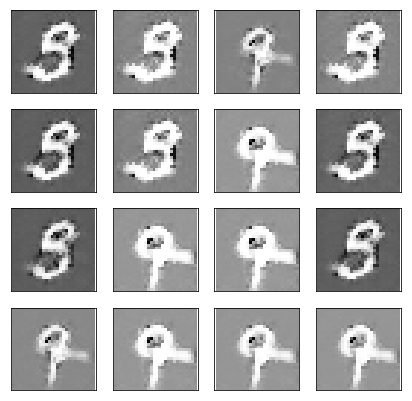

Epoch 5/10... Discriminator Loss: 0.0141... Generator Loss: 5.0498
Epoch 5/10... Discriminator Loss: 0.0162... Generator Loss: 4.9152
Epoch 5/10... Discriminator Loss: 0.0074... Generator Loss: 5.6028
Epoch 5/10... Discriminator Loss: 0.0107... Generator Loss: 5.3836
Epoch 5/10... Discriminator Loss: 0.0255... Generator Loss: 4.4434
Epoch 5/10... Discriminator Loss: 0.0122... Generator Loss: 5.1612
Epoch 5/10... Discriminator Loss: 0.0098... Generator Loss: 7.5685
Epoch 5/10... Discriminator Loss: 0.0075... Generator Loss: 5.7112
Epoch 5/10... Discriminator Loss: 0.0106... Generator Loss: 5.5685
Epoch 5/10... Discriminator Loss: 0.0078... Generator Loss: 5.5386


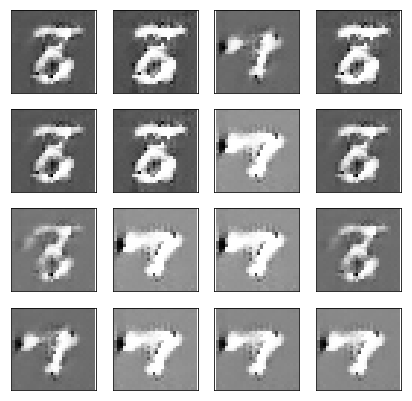

Epoch 5/10... Discriminator Loss: 0.0073... Generator Loss: 6.2367
Epoch 5/10... Discriminator Loss: 0.0078... Generator Loss: 5.3679
Epoch 5/10... Discriminator Loss: 0.0218... Generator Loss: 4.2386
Epoch 5/10... Discriminator Loss: 0.0137... Generator Loss: 6.6735
Epoch 5/10... Discriminator Loss: 0.0116... Generator Loss: 7.2170
Epoch 5/10... Discriminator Loss: 0.0107... Generator Loss: 5.5734
Epoch 5/10... Discriminator Loss: 0.0040... Generator Loss: 5.9849
Epoch 5/10... Discriminator Loss: 0.0049... Generator Loss: 6.3204
Epoch 5/10... Discriminator Loss: 0.0120... Generator Loss: 5.0347
Epoch 5/10... Discriminator Loss: 0.0136... Generator Loss: 4.8081


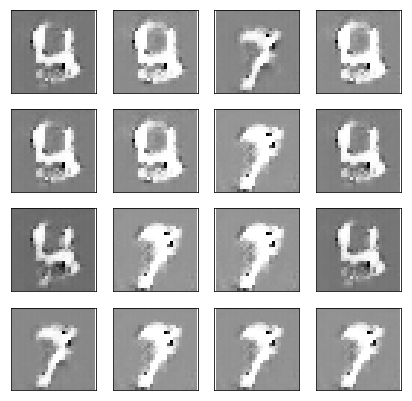

Epoch 5/10... Discriminator Loss: 0.0067... Generator Loss: 6.4438
Epoch 5/10... Discriminator Loss: 0.0041... Generator Loss: 6.1483
Epoch 5/10... Discriminator Loss: 0.0050... Generator Loss: 5.9818
Epoch 5/10... Discriminator Loss: 0.0051... Generator Loss: 5.7524
Epoch 5/10... Discriminator Loss: 0.0099... Generator Loss: 5.4665
Epoch 5/10... Discriminator Loss: 0.0080... Generator Loss: 5.4408
Epoch 5/10... Discriminator Loss: 0.0082... Generator Loss: 5.7651
Epoch 5/10... Discriminator Loss: 0.0149... Generator Loss: 5.6387
Epoch 5/10... Discriminator Loss: 0.0199... Generator Loss: 4.7909
Epoch 5/10... Discriminator Loss: 0.0086... Generator Loss: 5.6189


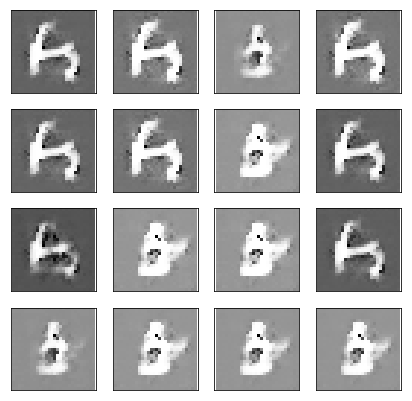

Epoch 5/10... Discriminator Loss: 0.0059... Generator Loss: 5.6930
Epoch 5/10... Discriminator Loss: 0.0030... Generator Loss: 6.5829
Epoch 5/10... Discriminator Loss: 0.0092... Generator Loss: 5.6798
Epoch 5/10... Discriminator Loss: 0.0089... Generator Loss: 5.3732
Epoch 6/10... Discriminator Loss: 0.0056... Generator Loss: 5.8976
Epoch 6/10... Discriminator Loss: 0.0093... Generator Loss: 5.4273
Epoch 6/10... Discriminator Loss: 0.0231... Generator Loss: 4.2819
Epoch 6/10... Discriminator Loss: 0.0078... Generator Loss: 6.2183
Epoch 6/10... Discriminator Loss: 0.0021... Generator Loss: 7.6211
Epoch 6/10... Discriminator Loss: 0.0147... Generator Loss: 4.7424


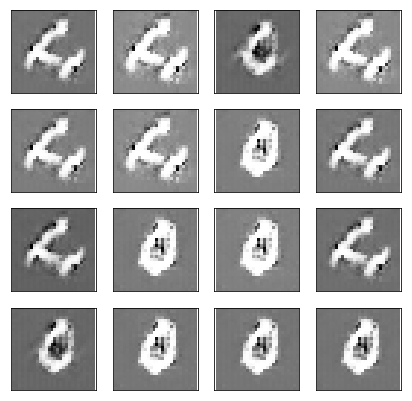

Epoch 6/10... Discriminator Loss: 0.0076... Generator Loss: 5.2986
Epoch 6/10... Discriminator Loss: 0.0171... Generator Loss: 4.5003
Epoch 6/10... Discriminator Loss: 0.0088... Generator Loss: 5.6603
Epoch 6/10... Discriminator Loss: 0.0069... Generator Loss: 6.1947
Epoch 6/10... Discriminator Loss: 0.0038... Generator Loss: 6.6112
Epoch 6/10... Discriminator Loss: 0.0090... Generator Loss: 6.4095
Epoch 6/10... Discriminator Loss: 0.0027... Generator Loss: 7.7469
Epoch 6/10... Discriminator Loss: 0.0054... Generator Loss: 6.5390
Epoch 6/10... Discriminator Loss: 0.0207... Generator Loss: 4.6231
Epoch 6/10... Discriminator Loss: 0.0060... Generator Loss: 6.5506


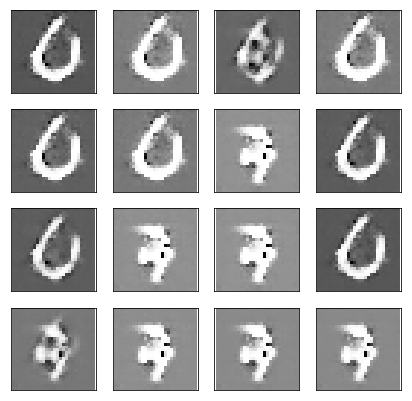

Epoch 6/10... Discriminator Loss: 0.0144... Generator Loss: 5.2283
Epoch 6/10... Discriminator Loss: 0.0055... Generator Loss: 6.8190
Epoch 6/10... Discriminator Loss: 0.1371... Generator Loss: 14.7169
Epoch 6/10... Discriminator Loss: 0.0036... Generator Loss: 7.1289
Epoch 6/10... Discriminator Loss: 0.0010... Generator Loss: 9.0124
Epoch 6/10... Discriminator Loss: 0.0075... Generator Loss: 6.1191
Epoch 6/10... Discriminator Loss: 0.0037... Generator Loss: 7.1513
Epoch 6/10... Discriminator Loss: 0.0127... Generator Loss: 5.0356
Epoch 6/10... Discriminator Loss: 0.0038... Generator Loss: 6.6807
Epoch 6/10... Discriminator Loss: 0.0036... Generator Loss: 6.1522


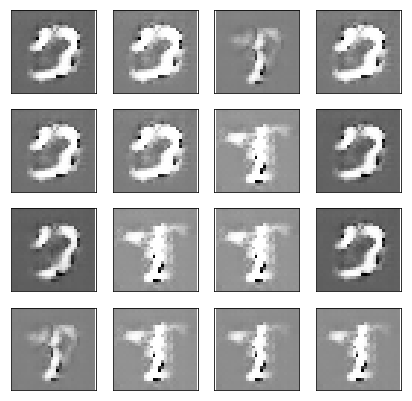

Epoch 6/10... Discriminator Loss: 0.1481... Generator Loss: 13.2704
Epoch 6/10... Discriminator Loss: 0.1355... Generator Loss: 4.1598
Epoch 6/10... Discriminator Loss: 0.0276... Generator Loss: 4.7074
Epoch 6/10... Discriminator Loss: 0.0208... Generator Loss: 4.3441
Epoch 6/10... Discriminator Loss: 0.0169... Generator Loss: 4.5533
Epoch 6/10... Discriminator Loss: 0.0157... Generator Loss: 4.7773
Epoch 6/10... Discriminator Loss: 0.0160... Generator Loss: 4.6380
Epoch 6/10... Discriminator Loss: 0.0157... Generator Loss: 5.2440
Epoch 6/10... Discriminator Loss: 0.0191... Generator Loss: 4.9539
Epoch 6/10... Discriminator Loss: 0.0197... Generator Loss: 4.8476


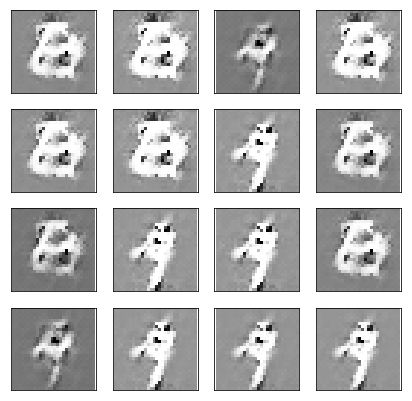

Epoch 6/10... Discriminator Loss: 0.0137... Generator Loss: 5.0364
Epoch 6/10... Discriminator Loss: 0.0139... Generator Loss: 4.6650
Epoch 6/10... Discriminator Loss: 0.0198... Generator Loss: 5.5192
Epoch 6/10... Discriminator Loss: 0.0112... Generator Loss: 5.2523
Epoch 6/10... Discriminator Loss: 0.0244... Generator Loss: 4.5826
Epoch 6/10... Discriminator Loss: 0.0199... Generator Loss: 4.7469
Epoch 6/10... Discriminator Loss: 0.0189... Generator Loss: 6.9138
Epoch 6/10... Discriminator Loss: 0.0139... Generator Loss: 5.4939
Epoch 6/10... Discriminator Loss: 0.0239... Generator Loss: 4.2698
Epoch 6/10... Discriminator Loss: 0.0416... Generator Loss: 3.6230


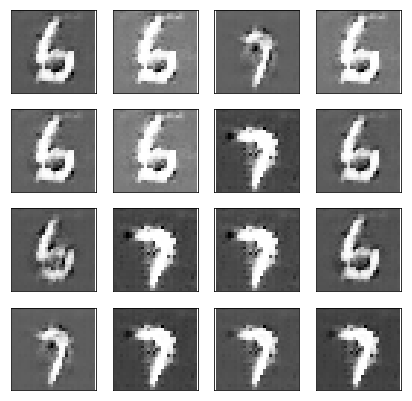

Epoch 7/10... Discriminator Loss: 0.0115... Generator Loss: 5.1061
Epoch 7/10... Discriminator Loss: 0.0100... Generator Loss: 5.3574
Epoch 7/10... Discriminator Loss: 0.0215... Generator Loss: 4.6267
Epoch 7/10... Discriminator Loss: 0.0185... Generator Loss: 5.1743
Epoch 7/10... Discriminator Loss: 0.0098... Generator Loss: 5.2717
Epoch 7/10... Discriminator Loss: 0.0091... Generator Loss: 5.5400
Epoch 7/10... Discriminator Loss: 0.0108... Generator Loss: 5.5158
Epoch 7/10... Discriminator Loss: 0.0155... Generator Loss: 5.3727
Epoch 7/10... Discriminator Loss: 0.0104... Generator Loss: 5.4057
Epoch 7/10... Discriminator Loss: 0.0055... Generator Loss: 6.0453


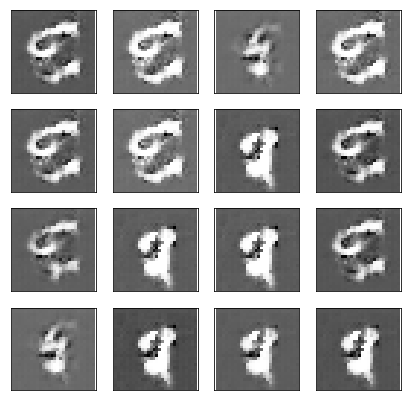

Epoch 7/10... Discriminator Loss: 0.0089... Generator Loss: 5.5197
Epoch 7/10... Discriminator Loss: 0.0066... Generator Loss: 5.6157
Epoch 7/10... Discriminator Loss: 0.0106... Generator Loss: 5.3330
Epoch 7/10... Discriminator Loss: 0.0196... Generator Loss: 4.6169
Epoch 7/10... Discriminator Loss: 0.0062... Generator Loss: 5.6473
Epoch 7/10... Discriminator Loss: 0.0090... Generator Loss: 5.8812
Epoch 7/10... Discriminator Loss: 0.0128... Generator Loss: 6.5251
Epoch 7/10... Discriminator Loss: 0.0121... Generator Loss: 5.1220
Epoch 7/10... Discriminator Loss: 0.0058... Generator Loss: 5.8244
Epoch 7/10... Discriminator Loss: 0.0065... Generator Loss: 5.8821


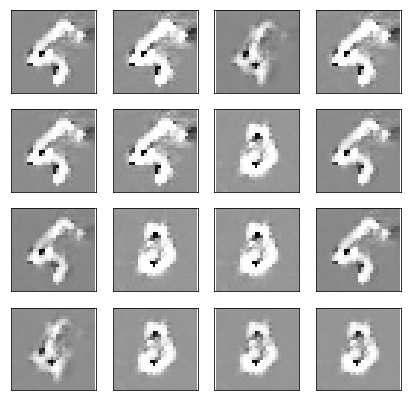

Epoch 7/10... Discriminator Loss: 0.0105... Generator Loss: 5.3912
Epoch 7/10... Discriminator Loss: 0.0118... Generator Loss: 5.2901
Epoch 7/10... Discriminator Loss: 0.0113... Generator Loss: 5.2596
Epoch 7/10... Discriminator Loss: 0.0069... Generator Loss: 6.3498
Epoch 7/10... Discriminator Loss: 0.0128... Generator Loss: 4.9748
Epoch 7/10... Discriminator Loss: 0.0053... Generator Loss: 5.6852
Epoch 7/10... Discriminator Loss: 0.0079... Generator Loss: 5.7803
Epoch 7/10... Discriminator Loss: 0.0077... Generator Loss: 6.2413
Epoch 7/10... Discriminator Loss: 0.0057... Generator Loss: 6.1592
Epoch 7/10... Discriminator Loss: 0.0054... Generator Loss: 5.9980


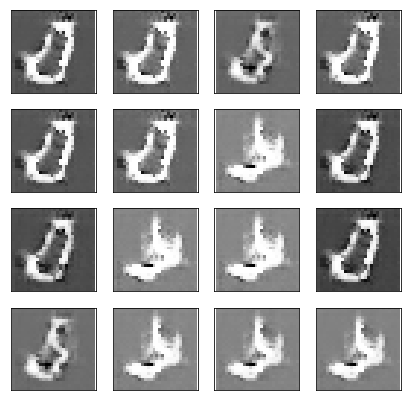

Epoch 7/10... Discriminator Loss: 0.0050... Generator Loss: 6.3016
Epoch 7/10... Discriminator Loss: 0.0041... Generator Loss: 6.2874
Epoch 7/10... Discriminator Loss: 0.0026... Generator Loss: 6.2498
Epoch 7/10... Discriminator Loss: 0.0051... Generator Loss: 5.7448
Epoch 7/10... Discriminator Loss: 0.0030... Generator Loss: 6.3564
Epoch 7/10... Discriminator Loss: 0.0045... Generator Loss: 6.5002
Epoch 7/10... Discriminator Loss: 0.0111... Generator Loss: 5.0824
Epoch 7/10... Discriminator Loss: 0.0145... Generator Loss: 4.5801
Epoch 7/10... Discriminator Loss: 0.0056... Generator Loss: 5.6990
Epoch 7/10... Discriminator Loss: 0.0093... Generator Loss: 5.3352


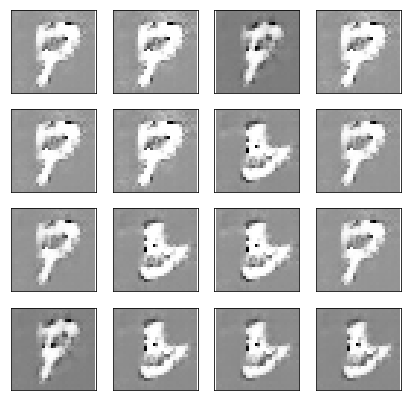

Epoch 7/10... Discriminator Loss: 0.0063... Generator Loss: 5.6374
Epoch 7/10... Discriminator Loss: 0.0063... Generator Loss: 5.5297
Epoch 7/10... Discriminator Loss: 0.0049... Generator Loss: 5.6880
Epoch 7/10... Discriminator Loss: 0.0061... Generator Loss: 5.7122
Epoch 7/10... Discriminator Loss: 0.0060... Generator Loss: 6.0043
Epoch 7/10... Discriminator Loss: 0.0048... Generator Loss: 6.9425
Epoch 7/10... Discriminator Loss: 0.0080... Generator Loss: 6.1438
Epoch 8/10... Discriminator Loss: 0.0916... Generator Loss: 7.3420
Epoch 8/10... Discriminator Loss: 0.0458... Generator Loss: 4.1988
Epoch 8/10... Discriminator Loss: 0.0298... Generator Loss: 4.5138


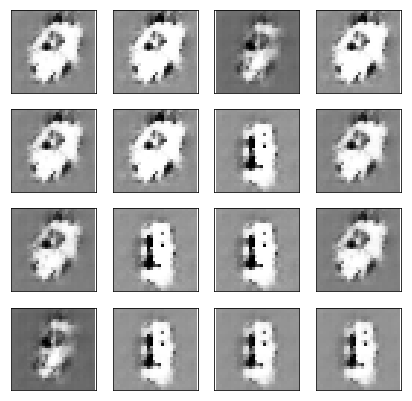

Epoch 8/10... Discriminator Loss: 0.0267... Generator Loss: 4.4439
Epoch 8/10... Discriminator Loss: 0.0221... Generator Loss: 4.5069
Epoch 8/10... Discriminator Loss: 0.0295... Generator Loss: 4.3792
Epoch 8/10... Discriminator Loss: 0.0302... Generator Loss: 4.5323
Epoch 8/10... Discriminator Loss: 0.0303... Generator Loss: 4.6879
Epoch 8/10... Discriminator Loss: 0.0157... Generator Loss: 5.0889
Epoch 8/10... Discriminator Loss: 0.0165... Generator Loss: 5.1415
Epoch 8/10... Discriminator Loss: 0.0233... Generator Loss: 4.8847
Epoch 8/10... Discriminator Loss: 0.0165... Generator Loss: 4.8976
Epoch 8/10... Discriminator Loss: 0.0226... Generator Loss: 4.4604


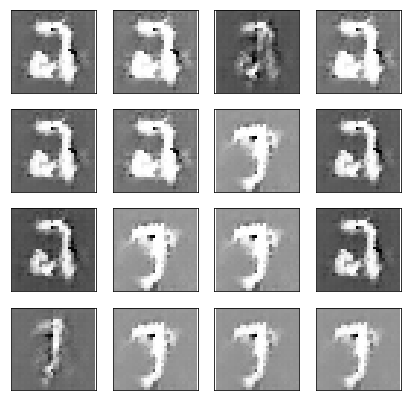

Epoch 8/10... Discriminator Loss: 0.0154... Generator Loss: 4.7558
Epoch 8/10... Discriminator Loss: 0.0146... Generator Loss: 5.2171
Epoch 8/10... Discriminator Loss: 0.0159... Generator Loss: 4.9309
Epoch 8/10... Discriminator Loss: 0.0096... Generator Loss: 5.5365
Epoch 8/10... Discriminator Loss: 0.0176... Generator Loss: 5.1223
Epoch 8/10... Discriminator Loss: 0.0206... Generator Loss: 4.8593
Epoch 8/10... Discriminator Loss: 0.0145... Generator Loss: 5.2071
Epoch 8/10... Discriminator Loss: 0.0117... Generator Loss: 5.6467
Epoch 8/10... Discriminator Loss: 0.0106... Generator Loss: 5.3413
Epoch 8/10... Discriminator Loss: 0.0093... Generator Loss: 5.3903


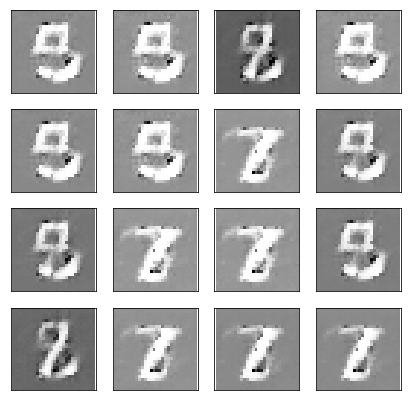

Epoch 8/10... Discriminator Loss: 0.0188... Generator Loss: 4.9800
Epoch 8/10... Discriminator Loss: 0.0180... Generator Loss: 5.4107
Epoch 8/10... Discriminator Loss: 0.0229... Generator Loss: 4.2748
Epoch 8/10... Discriminator Loss: 0.0145... Generator Loss: 5.1208
Epoch 8/10... Discriminator Loss: 0.0202... Generator Loss: 4.6656
Epoch 8/10... Discriminator Loss: 0.0091... Generator Loss: 5.5388
Epoch 8/10... Discriminator Loss: 0.0084... Generator Loss: 5.3130
Epoch 8/10... Discriminator Loss: 0.0105... Generator Loss: 5.2497
Epoch 8/10... Discriminator Loss: 0.0067... Generator Loss: 5.4652
Epoch 8/10... Discriminator Loss: 0.0070... Generator Loss: 6.0088


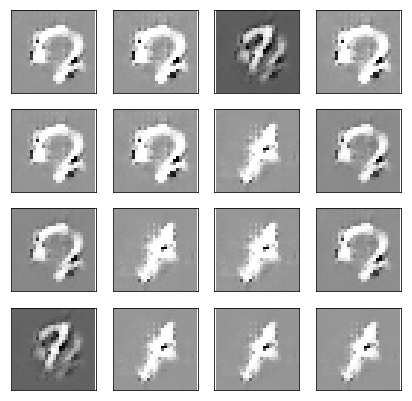

Epoch 8/10... Discriminator Loss: 0.0076... Generator Loss: 5.8575
Epoch 8/10... Discriminator Loss: 0.0122... Generator Loss: 5.6311
Epoch 8/10... Discriminator Loss: 0.0102... Generator Loss: 5.8524
Epoch 8/10... Discriminator Loss: 0.0122... Generator Loss: 5.6287
Epoch 8/10... Discriminator Loss: 0.0092... Generator Loss: 5.8123
Epoch 8/10... Discriminator Loss: 0.0082... Generator Loss: 5.5242
Epoch 8/10... Discriminator Loss: 0.0104... Generator Loss: 5.7934
Epoch 8/10... Discriminator Loss: 0.0105... Generator Loss: 5.0224
Epoch 8/10... Discriminator Loss: 0.0107... Generator Loss: 5.4476
Epoch 8/10... Discriminator Loss: 0.0027... Generator Loss: 6.3802


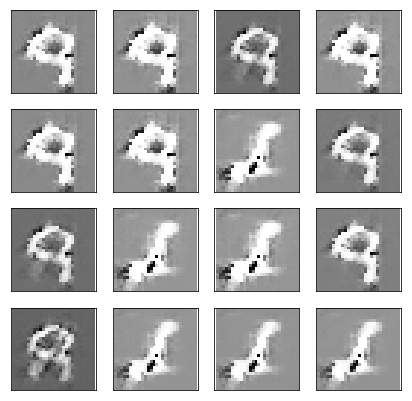

Epoch 8/10... Discriminator Loss: 0.0100... Generator Loss: 5.4394
Epoch 8/10... Discriminator Loss: 0.0060... Generator Loss: 5.8924
Epoch 8/10... Discriminator Loss: 0.0064... Generator Loss: 6.0949
Epoch 8/10... Discriminator Loss: 0.0057... Generator Loss: 5.7851
Epoch 9/10... Discriminator Loss: 0.0064... Generator Loss: 5.5054
Epoch 9/10... Discriminator Loss: 0.0054... Generator Loss: 5.6466
Epoch 9/10... Discriminator Loss: 0.0040... Generator Loss: 5.9406
Epoch 9/10... Discriminator Loss: 0.0063... Generator Loss: 5.4752
Epoch 9/10... Discriminator Loss: 0.0058... Generator Loss: 6.0733
Epoch 9/10... Discriminator Loss: 0.0089... Generator Loss: 5.2670


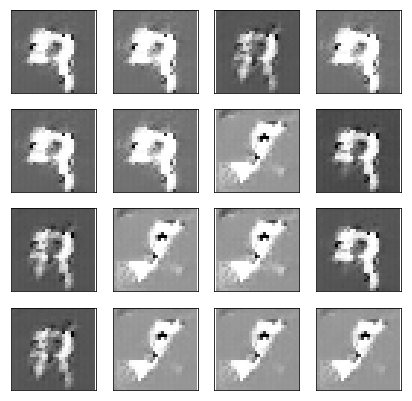

Epoch 9/10... Discriminator Loss: 0.0068... Generator Loss: 5.5869
Epoch 9/10... Discriminator Loss: 0.0094... Generator Loss: 5.2773
Epoch 9/10... Discriminator Loss: 0.0035... Generator Loss: 6.6394
Epoch 9/10... Discriminator Loss: 0.0096... Generator Loss: 5.8592
Epoch 9/10... Discriminator Loss: 0.0199... Generator Loss: 4.4851
Epoch 9/10... Discriminator Loss: 0.0069... Generator Loss: 5.8596
Epoch 9/10... Discriminator Loss: 0.0098... Generator Loss: 5.6611
Epoch 9/10... Discriminator Loss: 0.0110... Generator Loss: 5.0456
Epoch 9/10... Discriminator Loss: 0.0132... Generator Loss: 6.3726
Epoch 9/10... Discriminator Loss: 0.0050... Generator Loss: 6.1961


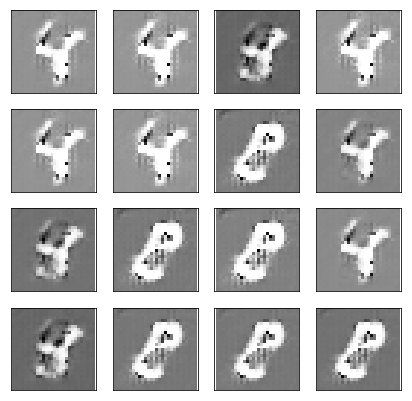

Epoch 9/10... Discriminator Loss: 0.0057... Generator Loss: 6.4095
Epoch 9/10... Discriminator Loss: 0.0061... Generator Loss: 7.0921
Epoch 9/10... Discriminator Loss: 0.0050... Generator Loss: 6.0624
Epoch 9/10... Discriminator Loss: 0.0042... Generator Loss: 5.8845
Epoch 9/10... Discriminator Loss: 0.0036... Generator Loss: 6.2829
Epoch 9/10... Discriminator Loss: 0.0100... Generator Loss: 5.6234
Epoch 9/10... Discriminator Loss: 0.0052... Generator Loss: 5.5893
Epoch 9/10... Discriminator Loss: 0.0144... Generator Loss: 5.0417
Epoch 9/10... Discriminator Loss: 0.0077... Generator Loss: 5.5116
Epoch 9/10... Discriminator Loss: 0.0060... Generator Loss: 6.8566


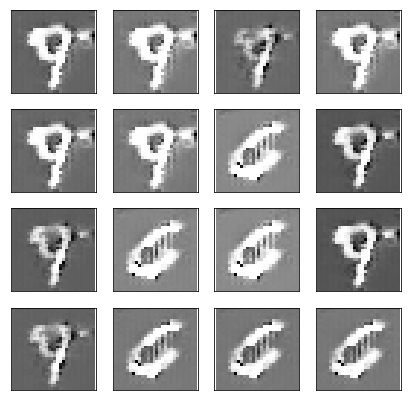

Epoch 9/10... Discriminator Loss: 0.0060... Generator Loss: 6.1297
Epoch 9/10... Discriminator Loss: 0.0102... Generator Loss: 5.6875
Epoch 9/10... Discriminator Loss: 0.0025... Generator Loss: 6.8791
Epoch 9/10... Discriminator Loss: 0.0029... Generator Loss: 8.3336
Epoch 9/10... Discriminator Loss: 0.0026... Generator Loss: 7.6139
Epoch 9/10... Discriminator Loss: 0.0029... Generator Loss: 7.7230
Epoch 9/10... Discriminator Loss: 0.1281... Generator Loss: 2.8214
Epoch 9/10... Discriminator Loss: 0.3633... Generator Loss: 4.2126
Epoch 9/10... Discriminator Loss: 0.0323... Generator Loss: 3.9396
Epoch 9/10... Discriminator Loss: 0.0331... Generator Loss: 4.3804


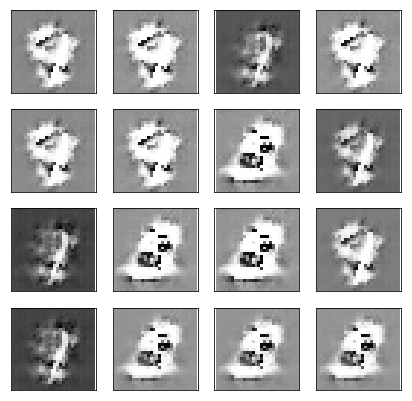

Epoch 9/10... Discriminator Loss: 0.0452... Generator Loss: 4.0733
Epoch 9/10... Discriminator Loss: 0.0425... Generator Loss: 4.0776
Epoch 9/10... Discriminator Loss: 0.0169... Generator Loss: 4.5425
Epoch 9/10... Discriminator Loss: 0.0201... Generator Loss: 4.6798
Epoch 9/10... Discriminator Loss: 0.0217... Generator Loss: 4.9666
Epoch 9/10... Discriminator Loss: 0.0174... Generator Loss: 4.8421
Epoch 9/10... Discriminator Loss: 0.0213... Generator Loss: 4.6161
Epoch 9/10... Discriminator Loss: 0.0123... Generator Loss: 5.1699
Epoch 9/10... Discriminator Loss: 0.0126... Generator Loss: 4.9423
Epoch 9/10... Discriminator Loss: 0.0121... Generator Loss: 5.1837


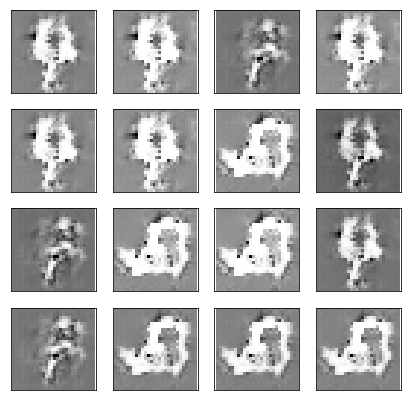

Epoch 9/10... Discriminator Loss: 0.0189... Generator Loss: 4.6523
Epoch 10/10... Discriminator Loss: 0.0109... Generator Loss: 5.1455
Epoch 10/10... Discriminator Loss: 0.0102... Generator Loss: 5.0108
Epoch 10/10... Discriminator Loss: 0.0082... Generator Loss: 5.1699
Epoch 10/10... Discriminator Loss: 0.0120... Generator Loss: 5.1754
Epoch 10/10... Discriminator Loss: 0.0114... Generator Loss: 5.2438
Epoch 10/10... Discriminator Loss: 0.0155... Generator Loss: 4.9075
Epoch 10/10... Discriminator Loss: 0.0218... Generator Loss: 4.6448
Epoch 10/10... Discriminator Loss: 0.0152... Generator Loss: 4.6718
Epoch 10/10... Discriminator Loss: 0.0304... Generator Loss: 4.1009


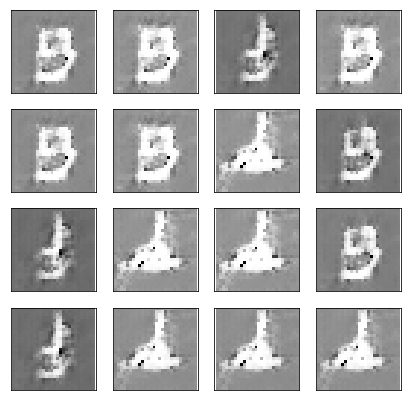

Epoch 10/10... Discriminator Loss: 0.0208... Generator Loss: 4.6992
Epoch 10/10... Discriminator Loss: 0.0087... Generator Loss: 5.5587
Epoch 10/10... Discriminator Loss: 0.0122... Generator Loss: 5.2316
Epoch 10/10... Discriminator Loss: 0.0134... Generator Loss: 5.3856
Epoch 10/10... Discriminator Loss: 0.0139... Generator Loss: 5.4106
Epoch 10/10... Discriminator Loss: 0.0270... Generator Loss: 4.7130
Epoch 10/10... Discriminator Loss: 0.0115... Generator Loss: 5.2523
Epoch 10/10... Discriminator Loss: 0.0133... Generator Loss: 5.3464
Epoch 10/10... Discriminator Loss: 0.0121... Generator Loss: 5.7160
Epoch 10/10... Discriminator Loss: 0.0127... Generator Loss: 5.2206


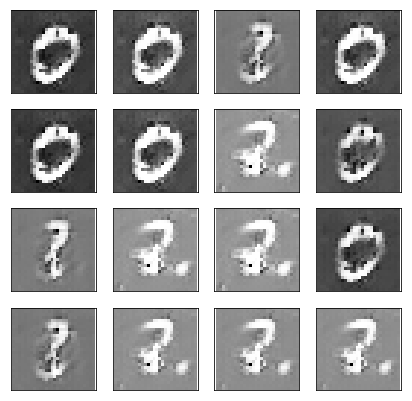

Epoch 10/10... Discriminator Loss: 0.0158... Generator Loss: 4.9482
Epoch 10/10... Discriminator Loss: 0.0119... Generator Loss: 5.6735
Epoch 10/10... Discriminator Loss: 0.0115... Generator Loss: 5.3586
Epoch 10/10... Discriminator Loss: 0.0142... Generator Loss: 5.2626
Epoch 10/10... Discriminator Loss: 0.0100... Generator Loss: 5.7061
Epoch 10/10... Discriminator Loss: 0.0090... Generator Loss: 5.3265
Epoch 10/10... Discriminator Loss: 0.0063... Generator Loss: 6.0494
Epoch 10/10... Discriminator Loss: 0.0079... Generator Loss: 5.4211
Epoch 10/10... Discriminator Loss: 0.0113... Generator Loss: 5.1748
Epoch 10/10... Discriminator Loss: 0.0191... Generator Loss: 4.5751


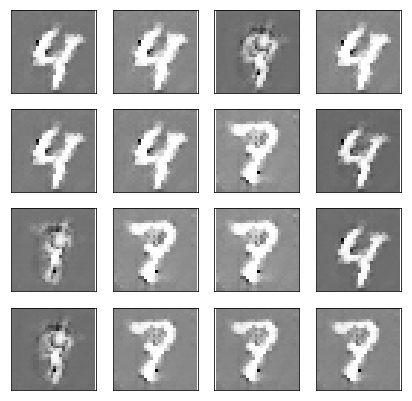

Epoch 10/10... Discriminator Loss: 0.0130... Generator Loss: 4.8585
Epoch 10/10... Discriminator Loss: 0.0137... Generator Loss: 5.0100
Epoch 10/10... Discriminator Loss: 0.0146... Generator Loss: 5.1472
Epoch 10/10... Discriminator Loss: 0.0083... Generator Loss: 5.7339
Epoch 10/10... Discriminator Loss: 0.0081... Generator Loss: 5.8327
Epoch 10/10... Discriminator Loss: 0.0088... Generator Loss: 5.8157
Epoch 10/10... Discriminator Loss: 0.0083... Generator Loss: 5.4094
Epoch 10/10... Discriminator Loss: 0.0075... Generator Loss: 5.6346
Epoch 10/10... Discriminator Loss: 0.0083... Generator Loss: 5.3026
Epoch 10/10... Discriminator Loss: 0.0060... Generator Loss: 6.1618


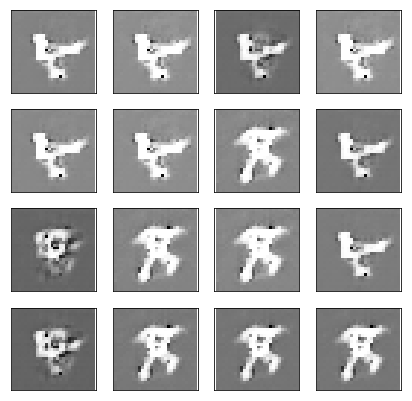

Epoch 10/10... Discriminator Loss: 0.0077... Generator Loss: 5.2532
Epoch 10/10... Discriminator Loss: 0.0032... Generator Loss: 6.4918
Epoch 10/10... Discriminator Loss: 0.0035... Generator Loss: 6.4467
Epoch 10/10... Discriminator Loss: 0.0045... Generator Loss: 5.9571
Epoch 10/10... Discriminator Loss: 0.0069... Generator Loss: 5.5546
Epoch 10/10... Discriminator Loss: 0.0041... Generator Loss: 6.3082
Epoch 10/10... Discriminator Loss: 0.0040... Generator Loss: 5.9865
Epoch 10/10... Discriminator Loss: 0.0074... Generator Loss: 5.6537


In [12]:
print_every = 10
show_every = 100

saver = tf.train.Saver()
sample_z = np.random.uniform(-1, 1, size=(72, z_size))

samples, losses = [], []
steps = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            steps += 1
            
            # Batch Images
            x = mnist.train.next_batch(batch_size)[0]
            
            # Sample random noise for Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
            _ = sess.run(g_opt, feed_dict={input_real: x, input_z: batch_z})
            
            if steps % print_every == 0:
                # At the end of each epoch, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))
                
            
            if steps % show_every == 0:
                gen_samples = sess.run(
                               generator(input_z, 1, reuse=True, training=False),
                               feed_dict={input_z: sample_z})
                samples.append(gen_samples)
                _ = view_samples(-1, samples)
                plt.show()

    saver.save(sess, './checkpoints/generator.ckpt')

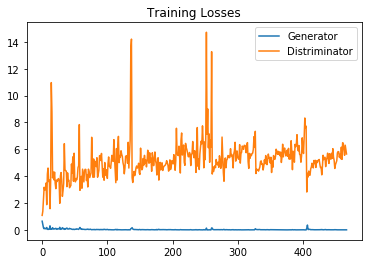

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Generator')
plt.plot(losses.T[1], label='Distriminator')
plt.title("Training Losses")
plt.legend()